## Creates binarized Seurat objects, and merges them and finds Top Features (min.cutoff=20)

In [1]:
# Input info
cellr_in <- "/data2/isshamie/mito_lineage/data/processed/mtscATAC/jan21_2021/MTblacklist"
samples <- "J2,P2"
sample_names <- "Flt3l,Ctrl"

# Saving
outdir <- "/data/isshamie/mito_lineage/output/annotation/cd34norm/MTblacklist/mergedSamples" #"/data2/mito_lineage/Analysis/annotation/output/data/"

# Parameters
nTop = 25000
assay="RNA"

cores = 36

In [2]:
samples <- unlist(strsplit(samples, ",")[[1]])
sample_names <- unlist(strsplit(sample_names, ","))

samples

[1] "J2" "P2"

In [4]:
library(GenomicRanges)
library(Seurat)
library(Signac)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v75)
library(ggplot2)
library(patchwork)
set.seed(1234)
library(data.table)
library(magrittr)
library(cowplot)
library(metap)
library(future)
plan()

plan("multiprocess", workers = cores)
#options(future.globals.maxSize = 50000 * 1024^2) # for 50 Gb RAM
#plan("multiprocess", workers = workers)
#options(future.globals.maxSize = 8000 * 1024^2)

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The follow

sequential:
- args: function (..., envir = parent.frame())
- tweaked: FALSE
- call: NULL

## Merge all peaks

In [5]:
peaks <- read.table(
      file = file.path(cellr_in, "J2", "outs", "filtered_peak_bc_matrix", "peaks.bed"),
      col.names = c("chr", "start", "end")
    )

In [6]:
read.peaks <- function(exp, cellr_in){
    print('here')
    print(file.path(cellr_in, exp, "outs", "filtered_peak_bc_matrix", "peaks.bed"))
    peaks <- read.table(
      file = file.path(cellr_in, exp, "outs", "filtered_peak_bc_matrix", "peaks.bed"),
      col.names = c("chr", "start", "end")
    )
    # convert to genomic ranges
    gr <- makeGRangesFromDataFrame(peaks)
    return(gr)
}


gr.full <- c(sapply(samples, read.peaks, cellr_in=cellr_in, USE.NAMES=F))

gr.full.c <- gr.full[[1]]
if (length(gr.full)>1){
    for (i in 2:length(gr.full)){
      gr.full.c <- c(gr.full.c, gr.full[[i]])
    }
}
combined.peaks <- reduce(x = c(gr.full.c))

# Filter out bad peaks based on length
peakwidths <- width(combined.peaks)
combined.peaks <- combined.peaks[peakwidths  < 10000 & peakwidths > 20]
combined.peaks

[1] "here"
[1] "/data2/isshamie/mito_lineage/data/processed/mtscATAC/jan21_2021/MTblacklist/J2/outs/filtered_peak_bc_matrix/peaks.bed"
[1] "here"
[1] "/data2/isshamie/mito_lineage/data/processed/mtscATAC/jan21_2021/MTblacklist/P2/outs/filtered_peak_bc_matrix/peaks.bed"


GRanges object with 149551 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]     chr1        9942-10364      *
       [2]     chr1     191685-191736      *
       [3]     chr1     267780-268257      *
       [4]     chr1     271072-271548      *
       [5]     chr1     585995-586411      *
       ...      ...               ...    ...
  [149547]     chrY 56844769-56845155      *
  [149548]     chrY 56846033-56848664      *
  [149549]     chrY 56849234-56851581      *
  [149550]     chrY 56857506-56857613      *
  [149551]     chrY 56873729-56874140      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

## Create fragment objects

In [7]:
# create_frag <- function(exp, cellr_in){
#     barcode_path <- file.path(cellr_in, exp, "outs", "filtered_peak_bc_matrix", "barcodes.tsv")    
#     barcodes <- readr::read_tsv(barcode_path, col_names = F) # %>% tidyr::unite(barcode)
#     frag_file <- file.path(cellr_in, exp, "outs", "fragments.tsv.gz")
#     # quantify multiome peaks in the scATAC-seq dataset
#     frags.curr <- CreateFragmentObject(path = frag_file,cells= barcodes[["X1"]])
#     barcodes <- as.data.frame(barcodes) %>%  tibble::column_to_rownames(var="X1") %>% tibble::add_column(proj=exp)
#     ## Quantify peaks
#     curr.counts <- FeatureMatrix(
#       fragments = frags.curr,
#       features = combined.peaks,
#       cells = rownames(barcodes),
#       process_n = 8
#     )
    
#     ## Create the objects
#     curr_assay <- CreateChromatinAssay(curr.counts, fragments = frags.curr)
#     curr <- CreateSeuratObject(curr_assay, assay = "ATAC", project=exp, meta.data=barcodes)
#     curr <- BinarizeCounts(curr)
#     return(curr)
# }
allSE = c()#[]

for (exp in samples) {
    print('exp')
    print(exp)
    
    barcode_path <- file.path(cellr_in, exp, "outs", "filtered_peak_bc_matrix", "barcodes.tsv")    
    barcodes <- readr::read_tsv(barcode_path, col_names = F) # %>% tidyr::unite(barcode)
    frag_file <- file.path(cellr_in, exp, "outs", "fragments.tsv.gz")
    # quantify multiome peaks in the scATAC-seq dataset
    barcodes <- as.data.frame(barcodes) %>%  tibble::column_to_rownames(var="X1") %>% tibble::add_column(proj=exp)
    print(head(barcodes))
    print("Creating fragments object")
    frags.curr <- CreateFragmentObject(path = frag_file, cells= rownames(barcodes))
    print(frags.curr)
    print("Quantifying peaks")
    ## Quantify peaks
    curr.counts <- FeatureMatrix(
      fragments = frags.curr,
      features = combined.peaks,
      cells = rownames(barcodes),
      process_n = cores
    )
    
    print("Creating chromatin assay")
    ## Create the objects
    curr_assay <- CreateChromatinAssay(curr.counts, fragments = frags.curr)
    curr <- CreateSeuratObject(curr_assay, assay = "ATAC", project=exp, meta.data=barcodes)
    curr <- BinarizeCounts(curr)
    allSE = c(allSE, curr)
    #return(curr)
}



[1] "exp"
[1] "J2"


Registered S3 method overwritten by 'cli':
  method     from         
  print.boxx spatstat.geom

── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  X1 = col_character()
)




                   proj
AAACGAAAGAGCTCCC-1   J2
AAACGAAAGCGATACG-1   J2
AAACGAAAGGCTTCGC-1   J2
AAACGAAAGTACAACA-1   J2
AAACGAACAACGTACT-1   J2
AAACGAACAAGCGGTA-1   J2
[1] "Creating fragments object"


Computing hash



A Fragment object for 12009 cells
[1] "Quantifying peaks"


Extracting reads overlapping genomic regions



[1] "Creating chromatin assay"
[1] "exp"
[1] "P2"



── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  X1 = col_character()
)




                   proj
AAACGAAAGAGGTCCA-1   P2
AAACGAAAGCGATACG-1   P2
AAACGAAAGTCGTGAG-1   P2
AAACGAACAATAGTGA-1   P2
AAACGAACACAATAAG-1   P2
AAACGAACACTGATAC-1   P2
[1] "Creating fragments object"


Computing hash



A Fragment object for 6875 cells
[1] "Quantifying peaks"


Extracting reads overlapping genomic regions



[1] "Creating chromatin assay"


In [10]:
allSE

[[1]]
An object of class Seurat 
149551 features across 12009 samples within 1 assay 
Active assay: ATAC (149551 features, 0 variable features)

[[2]]
An object of class Seurat 
149551 features across 6875 samples within 1 assay 
Active assay: ATAC (149551 features, 0 variable features)


In [9]:
#allSE <- sapply(samples, create_frag, cellr_in=cellr_in)

ERROR: Error in match.fun(FUN): object 'create_frag' not found


## Merge

In [15]:
# merge all datasets, adding a cell ID to make sure cell names are unique
combined <- merge(
  x = allSE[[1]],
  y = unlist(allSE[2:length(allSE)],use.names=FALSE), #allSE[2:length(allSE)],
  add.cell.ids = sample_names
)
combined[["ATAC"]]



ChromatinAssay data with 149551 features for 18884 cells
Variable features: 0 
Genome: 
Annotation present: FALSE 
Motifs present: FALSE 
Fragment files: 2 

In [16]:
combined <- FindTopFeatures(combined, min.cutoff = 20)
combined

An object of class Seurat 
149551 features across 18884 samples within 1 assay 
Active assay: ATAC (149551 features, 149467 variable features)

## Filter for low peak counts and low cell counts before dimRed and integrating  

Performing TF-IDF normalization

Running SVD

Scaling cell embeddings

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
00:34:43 UMAP embedding parameters a = 0.9922 b = 1.112

00:34:43 Read 18884 rows and found 49 numeric columns

00:34:43 Using Annoy for neighbor search, n_neighbors = 30

00:34:43 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

00:34:46 Writing NN index file to temp file /tmp/RtmpkrvQb5/file99294baaed0f

00:34:46 Searching Annoy index using 36 threads, search_k = 3000

00:34:46 Annoy recall = 100%

00:34:47 Commencing

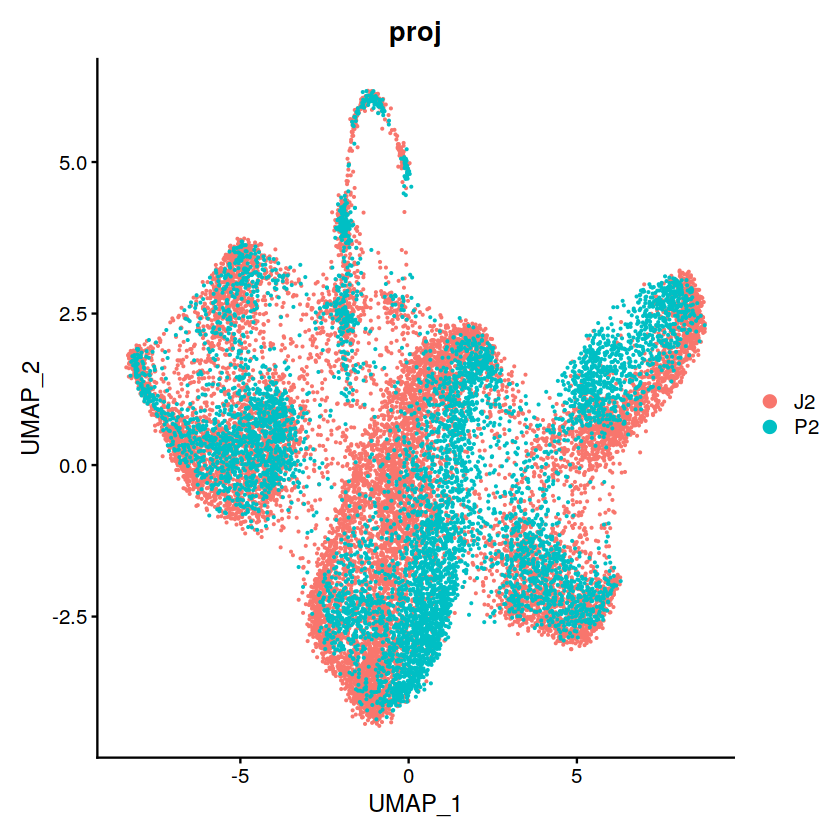

In [18]:
combined <- RunTFIDF(combined)
combined <- RunSVD(combined)
combined <- RunUMAP(combined, dims = 2:50, reduction = 'lsi')
DimPlot(combined, group.by = "proj", pt.size = 0.1)

In [17]:
saveRDS(combined, file.path(outdir, paste0("allSamples.merged.rds")))

## Integrate datasets
### Uses https://satijalab.org/signac/articles/integrate_atac.html

In [21]:
p1 <- DimPlot(combined, group.by = "proj")

In [24]:
options(future.globals.maxSize = 8000 * 1024^2)

In [27]:
ext <- subset(x = combined, subset = orig.ident == samples[1])
curr <- subset(x = combined, subset = orig.ident == samples[2])


In [29]:
# find integration anchors
integration.anchors <- FindIntegrationAnchors(
  object.list = c(ext,curr),
  anchor.features = rownames(ext),
  reduction = "rlsi",
  dims = 2:30
)

# integrate LSI embeddings
integrated <- IntegrateEmbeddings(
  anchorset = integration.anchors,
  reductions = combined[["lsi"]],
  new.reduction.name = "integrated_lsi",
  dims.to.integrate = 1:30
)



Computing within dataset neighborhoods

Finding all pairwise anchors

Warning message:
"No filtering performed if passing to data rather than counts"
Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 11379 anchors

Merging dataset 2 into 1

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

00:50:55 UMAP embedding parameters a = 0.9922 b = 1.112

00:50:55 Read 18884 rows and found 29 numeric columns

00:50:55 Using Annoy for neighbor search, n_neighbors = 30

00:50:55 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

00:50:58 Writing NN index file to temp file /tmp/RtmpkrvQb5/file992940afe98a

00:50:58 Searching Annoy index using 36 threads, sea

ERROR: Error: Cannot find 'dataset' in this Seurat object


In [30]:
# create a new UMAP using the integrated embeddings
integrated <- RunUMAP(integrated, reduction = "integrated_lsi", dims = 2:30)
p2 <- DimPlot(integrated, group.by = "proj")

00:56:58 UMAP embedding parameters a = 0.9922 b = 1.112

00:56:58 Read 18884 rows and found 29 numeric columns

00:56:58 Using Annoy for neighbor search, n_neighbors = 30

00:56:58 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

00:57:01 Writing NN index file to temp file /tmp/RtmpkrvQb5/file992964ba0650

00:57:01 Searching Annoy index using 36 threads, search_k = 3000

00:57:01 Annoy recall = 100%

00:57:03 Commencing smooth kNN distance calibration using 36 threads

00:57:05 Initializing from normalized Laplacian + noise

00:57:06 Commencing optimization for 200 epochs, with 874368 positive edges

00:57:18 Optimization finished



Saving 6.67 x 6.67 in image



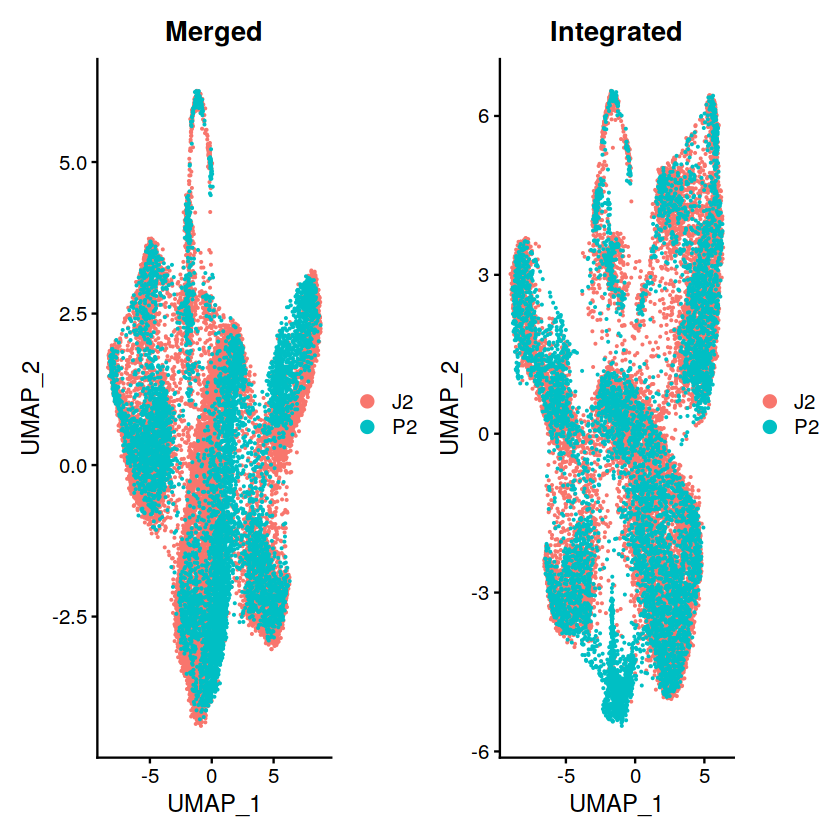

In [97]:
pclust <- DimPlot(object = integrated, label = TRUE) + NoLegend()

(p1 + ggtitle("Merged")) | (p2 + ggtitle("Integrated"))
ggsave(file.path(outdir,"integrated.merged.compare.png"))

Saving 6.67 x 6.67 in image



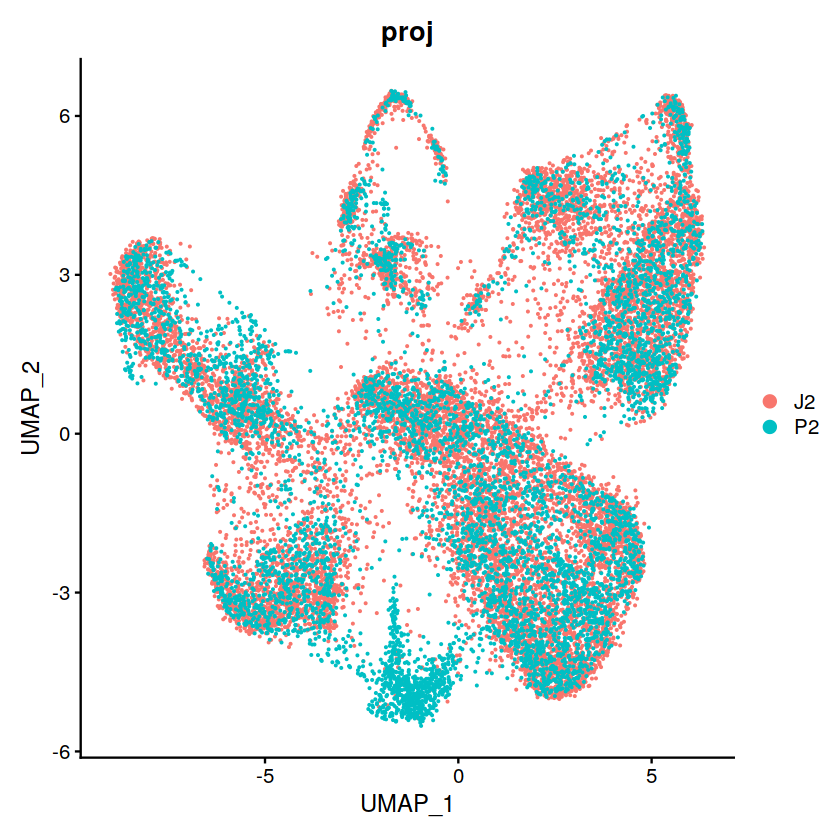

In [99]:
p2
ggsave(file.path(outdir,"integrated.batch.png"))

## Plot new cluster results

In [100]:
#integrated <- RunUMAP(object = integrated, reduction = 'integrated_lsi', dims = 2:30)
integrated <- FindNeighbors(object = integrated, reduction = 'integrated_lsi', dims = 2:30)
integrated <- FindClusters(object = integrated, verbose = FALSE, algorithm = 3)


20:13:31 UMAP embedding parameters a = 0.9922 b = 1.112

20:13:31 Read 18884 rows and found 29 numeric columns

20:13:31 Using Annoy for neighbor search, n_neighbors = 30

20:13:31 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

20:13:33 Writing NN index file to temp file /tmp/RtmpkrvQb5/file9929556c3b9e

20:13:33 Searching Annoy index using 36 threads, search_k = 3000

20:13:34 Annoy recall = 100%

20:13:36 Commencing smooth kNN distance calibration using 36 threads

20:13:39 Initializing from normalized Laplacian + noise

20:13:40 Commencing optimization for 200 epochs, with 874368 positive edges

20:13:52 Optimization finished

Computing nearest neighbor graph

Computing SNN



ERROR: Error in FindClusters.Seurat(object = integrated, verbose = FALSE, algorithm = 3): Provided graph.name not present in Seurat object


Saving 6.67 x 6.67 in image



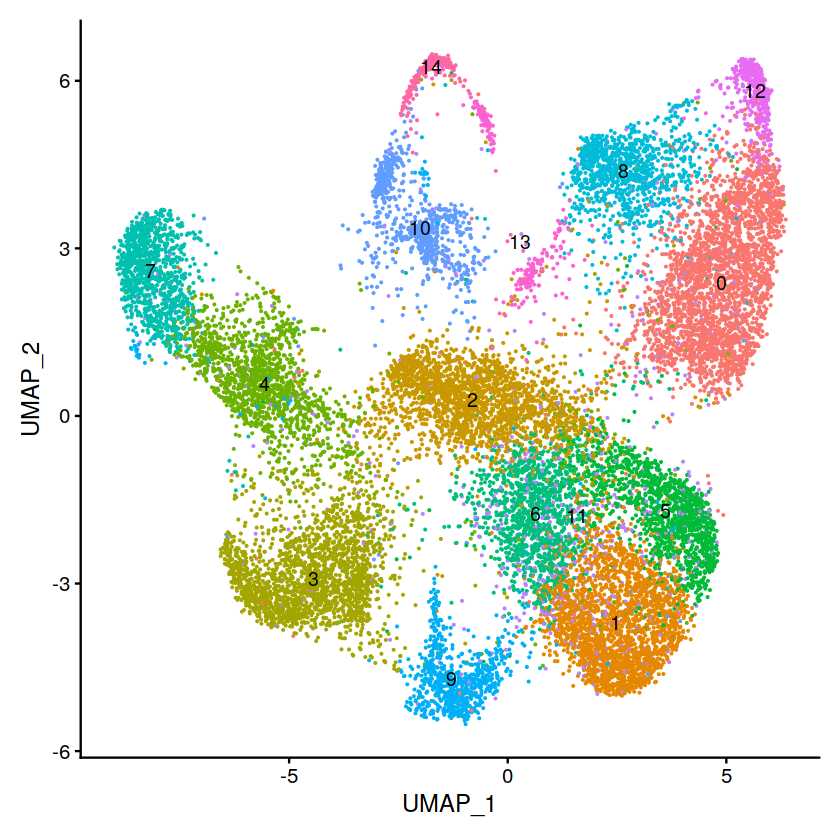

In [112]:
pclust <- DimPlot(object = integrated, label = TRUE) + NoLegend()
ggsave(file.path(outdir, "integrated.lsi.clusters.png"), pclust)
pclust

## ATAC DE peaks

In [50]:
# change back to working with peaks instead of gene activities
DefaultAssay(integrated) <- 'ATAC'

da_peaks <- FindMarkers(
  object = integrated,
  ident.1 = 9, #"CD4 Naive",
  min.pct = 0.05,
  test.use = 'LR',
  #latent.vars = 'peak_region_fragments'
)

head(da_peaks)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr15-75450105-75457083,1.476251e-69,-0.3721407,0.052,0.361,2.207748e-64
chr19-54187985-54191919,2.251582e-69,-0.3469831,0.034,0.315,3.367263e-64
chr1-149884334-149889371,1.951252e-68,-0.3673870,0.051,0.355,2.918117e-63
chr6-37168971-37178447,5.574467e-66,-0.3331878,0.036,0.305,8.336671e-61
chr6-27889224-27896489,5.169690e-62,-0.3620003,0.060,0.363,7.731323e-57
chr6-26194401-26200810,2.937203e-61,-0.3468335,0.054,0.341,4.392616e-56


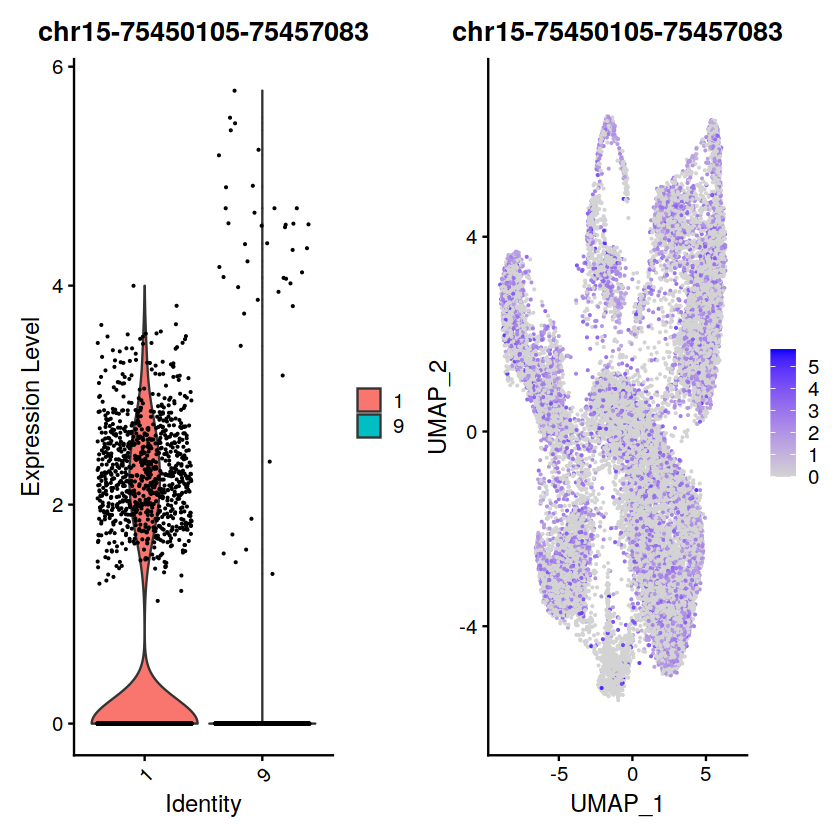

In [53]:
plot1 <- VlnPlot(
  object = integrated,
  features = rownames(da_peaks)[1],
  pt.size = 0.1,
  idents = c(1,9)
)
plot2 <- FeaturePlot(
  object = integrated,
  features = rownames(da_peaks)[1],
  pt.size = 0.1
)

plot1 | plot2


## Get gene activity results

In [35]:
# extract gene annotations from EnsDb
annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v75)

# change to UCSC style since the data was mapped to hg19
seqlevelsStyle(annotations) <- 'UCSC'
genome(annotations) <- "hg38"

# add the gene information to the object
Annotation(integrated) <- annotations


gene.activities <- GeneActivity(integrated)


Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

In [36]:
# add the gene activity matrix to the Seurat object as a new assay and normalize it
integrated[['RNA']] <- CreateAssayObject(counts = gene.activities)
integrated <- NormalizeData(
  object = integrated,
  assay = 'RNA',
  normalization.method = 'LogNormalize',
  scale.factor = median(integrated$nCount_RNA)
)

Warning message:
"Non-unique features (rownames) present in the input matrix, making unique"


## Compute DE for each cluster

In [57]:
# # change back to working with gene activities
# DefaultAssay(integrated) <- 'RNA'

# da_peaks <- FindMarkers(
#   object = integrated,
#   ident.1 = 9, #"CD4 Naive",
#   min.pct = 0.1,
#   test.use = 'LR',
#   #latent.vars = 'peak_region_fragments'
# )

# head(da_peaks)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
RBFOX2,4.729334e-113,-0.3443458,0.107,0.638,9.463398e-109
RPTOR,8.739170e-112,-0.3397834,0.133,0.666,1.748708e-107
FAM101A,5.700777e-101,-0.2586630,0.168,0.706,1.140726e-96
SEPT9,1.677760e-100,-0.3164069,0.114,0.624,3.357198e-96
RALGPS1,6.531853e-95,-0.2594329,0.139,0.658,1.307024e-90
NF1,3.858157e-94,-0.2721550,0.080,0.560,7.720173e-90


In [81]:
plotDE <- function(integrated, de.results, i, outdir){
    try
    {
    plot1 <- VlnPlot(
      object = integrated,
      features = rownames(de.results)[1],
      pt.size = 0.1,
      idents = i
    )
    plot2 <- FeaturePlot(
      object = integrated,
      features = rownames(de.results)[1],
      pt.size = 0.1
    )

    plot3 <- FeaturePlot(
      object = integrated,
      features = rownames(de.results)[2],
      pt.size = 0.1
    )
    
    plot1 | plot2 | plot3
    
    ggsave(file.path(outdir,paste0("cluster_",i,".DE.GeneActivity.top2.png")))
    
    return(c(plot1, plot2, plot3))
    }
    return
}

## Loop through each cluster and run DA for RNA-seq

In [83]:
cluster.ids <- sort(unique(Idents(integrated)))
for (i in cluster.ids){ #or however many clusters you have
try({
    print(paste("cluster", i))
    da.peaks <- FindMarkers(
                  object = integrated,
                  ident.1 = i, #"CD4 Naive",
                  min.pct = 0.1,
                  test.use = 'LR',
                )
    write.csv(da.peaks, file=file.path(outdir,paste0("cluster_",i,".DE.GeneActivity.csv")))
    print(paste('saved cluster', i))
    plotDE(integrated, da.peaks, i, outdir)
    print(paste('plotted cluster', i))
    
})
}

[1] "cluster 0"
[1] "saved cluster 0"


Saving 6.67 x 6.67 in image



[1] "plotted cluster 0"
[1] "cluster 1"
[1] "saved cluster 1"


Saving 6.67 x 6.67 in image



[1] "plotted cluster 1"
[1] "cluster 2"
[1] "saved cluster 2"


Saving 6.67 x 6.67 in image



[1] "plotted cluster 2"
[1] "cluster 3"
[1] "saved cluster 3"


Saving 6.67 x 6.67 in image



[1] "plotted cluster 3"
[1] "cluster 4"
[1] "saved cluster 4"


Saving 6.67 x 6.67 in image



[1] "plotted cluster 4"
[1] "cluster 5"
[1] "saved cluster 5"


Saving 6.67 x 6.67 in image



[1] "plotted cluster 5"
[1] "cluster 6"


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


[1] "saved cluster 6"
Error in FetchData(object = object, vars = features, slot = slot) : 
  None of the requested variables were found: NA
[1] "cluster 7"
[1] "saved cluster 7"


Saving 6.67 x 6.67 in image



[1] "plotted cluster 7"
[1] "cluster 8"
[1] "saved cluster 8"


Saving 6.67 x 6.67 in image



[1] "plotted cluster 8"
[1] "cluster 9"
[1] "saved cluster 9"


Saving 6.67 x 6.67 in image



[1] "plotted cluster 9"
[1] "cluster 10"
[1] "saved cluster 10"


Saving 6.67 x 6.67 in image



[1] "plotted cluster 10"
[1] "cluster 11"
[1] "saved cluster 11"


Saving 6.67 x 6.67 in image



[1] "plotted cluster 11"
[1] "cluster 12"
[1] "saved cluster 12"


Saving 6.67 x 6.67 in image



[1] "plotted cluster 12"
[1] "cluster 13"
[1] "saved cluster 13"


Saving 6.67 x 6.67 in image



[1] "plotted cluster 13"
[1] "cluster 14"
[1] "saved cluster 14"


Saving 6.67 x 6.67 in image



[1] "plotted cluster 14"


## Dotplots for clusters

### First feature plots

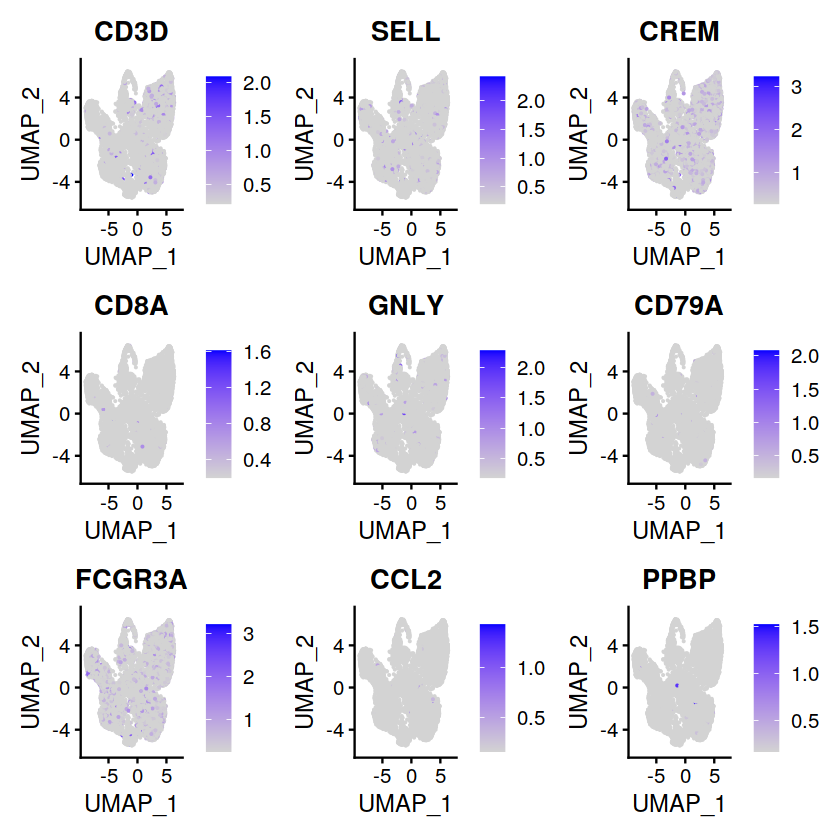

In [90]:
FeaturePlot(integrated, features = c("CD3D", "SELL", "CREM", "CD8A", "GNLY", "CD79A", "FCGR3A", 
    "CCL2", "PPBP"), min.cutoff = "q9")

### Immune markers taken from Seurat

Warning message in FetchData(object = object, vars = features, cells = cells):
"The following requested variables were not found: MIR155HG"


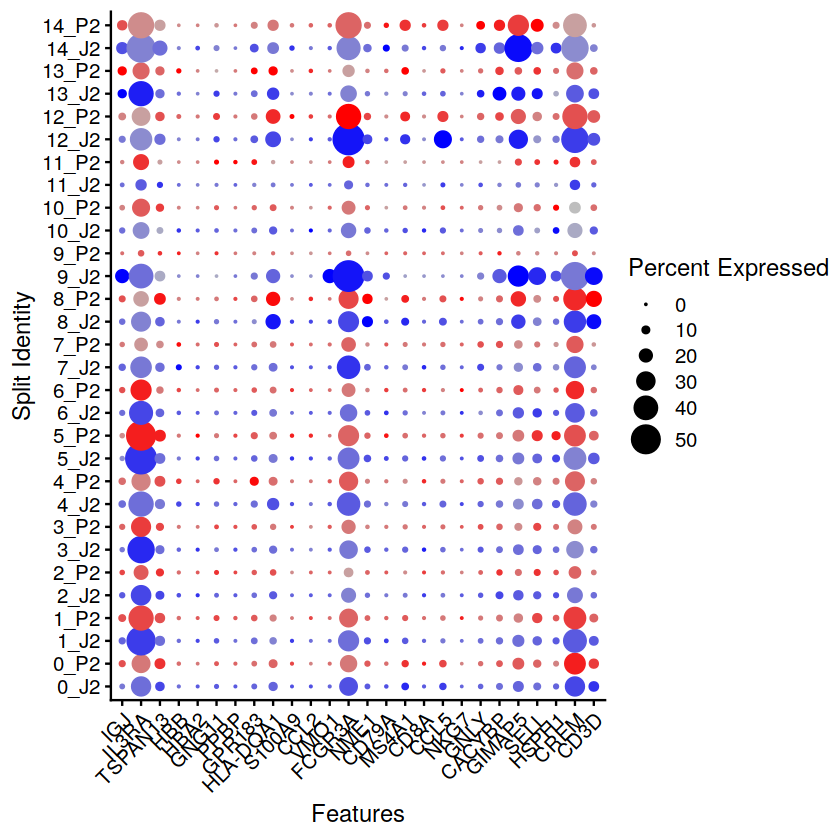

In [93]:
markers.to.plot <- c("CD3D", "CREM", "HSPH1", "SELL", "GIMAP5", "CACYBP", "GNLY", "NKG7", "CCL5", 
    "CD8A", "MS4A1", "CD79A", "MIR155HG", "NME1", "FCGR3A", "VMO1", "CCL2", "S100A9", "HLA-DQA1", 
    "GPR183", "PPBP", "GNG11", "HBA2", "HBB", "TSPAN13", "IL3RA", "IGJ")
DotPlot(integrated, features = rev(markers.to.plot), cols = c("blue", "red"), dot.scale = 8, 
    split.by = "orig.ident") + RotatedAxis()

### Immune markers taken from Dawn Lin et al Flt3l paper

Warning message in FetchData(object = object, vars = features, cells = cells):
"The following requested variables were not found: SLAMF2"


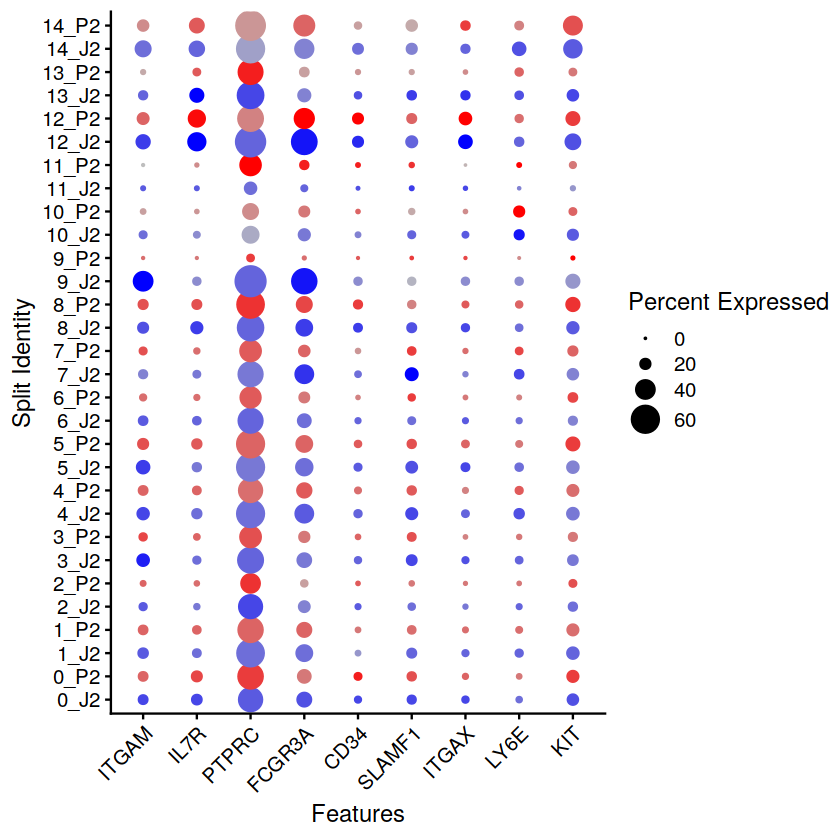

In [180]:
immune.markers = c('KIT',
                   'LY6E',
                   'ITGAX',
                   'SLAMF1',
                   'CD34',
                   'FCGR3A',
                   'PTPRC',
                   'SLAMF2',
                   'IL7R',
                   'ITGAM')

DotPlot(integrated, features = rev(immune.markers), cols = c("blue", "red"), dot.scale = 8, 
    split.by = "orig.ident") + RotatedAxis()

Warning message in FetchData(object = object, vars = c(dims, "ident", features), :
"The following requested variables were not found: SLAMF2"


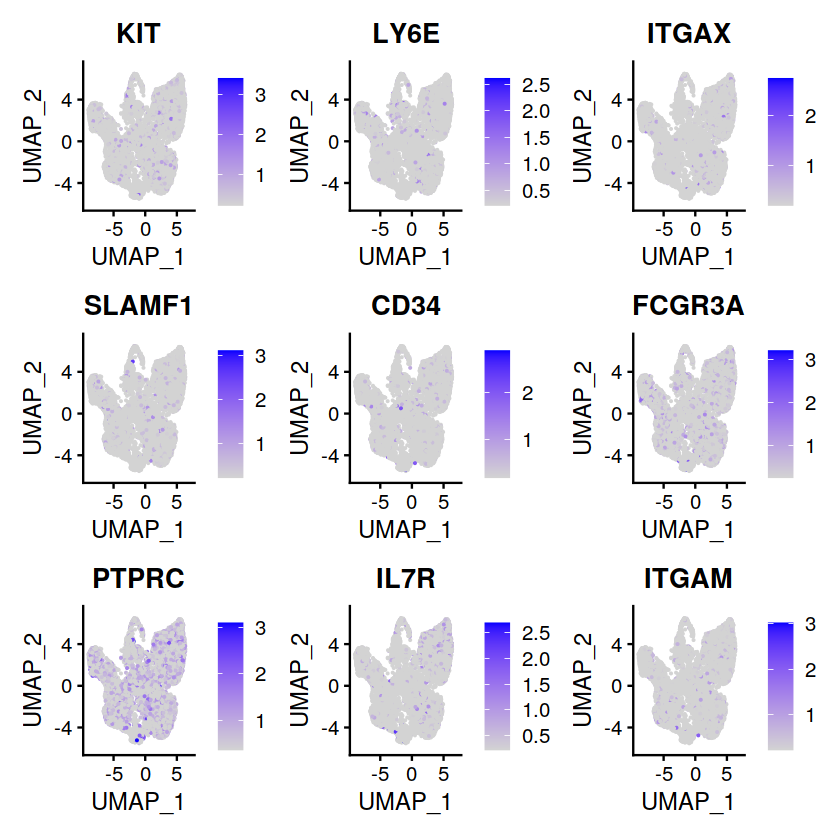

In [181]:
FeaturePlot(integrated, features = immune.markers, min.cutoff = "q9")

## Conserved markers to help idenify cell type

In [184]:
cluster.ids <- sort(unique(Idents(integrated)))
topMarkers = c()
for (i in cluster.ids){ #or however many clusters you have
try({
    print(paste("cluster", i))
    cons.markers <- FindConservedMarkers(integrated, ident.1 = i, 
                                         grouping.var = "orig.ident", verbose = TRUE)

    write.csv(cons.markers, file=file.path(outdir,paste0("cluster_",i,".conservedOverStim.GeneActivity.csv")))
    print(paste('saved cluster', i))
    print(head(cons.markers))
    topMarkers = c(topMarkers, rownames(cons.markers)[1])
    print(topMarkers)
})
}

head(cons.markers)

[1] "cluster 0"


Testing group P2: (0) vs (4, 3, 7, 12, 2, 13, 8, 1, 6, 10, 14, 9, 5, 11)

Testing group J2: (0) vs (5, 2, 6, 10, 7, 3, 12, 4, 14, 8, 11, 1, 13, 9)



[1] "saved cluster 0"
           P2_p_val P2_avg_log2FC P2_pct.1 P2_pct.2  P2_p_val_adj      J2_p_val
CPM   7.949623e-122     0.6760810    0.751    0.433 1.590720e-117 1.642990e-180
EDIL3  2.497963e-90     0.5892613    0.808    0.538  4.998424e-86 7.382055e-149
TPRG1  4.267713e-48     0.3567652    0.766    0.549  8.539694e-44  1.632973e-80
NUP37  2.710999e-59     0.2758398    0.361    0.147  5.424708e-55  4.933865e-67
RBM47  3.104155e-56     0.3876119    0.635    0.387  6.211415e-52  1.604725e-62
LYST   1.465469e-45     0.3314330    0.769    0.548  2.932404e-41  1.063213e-59
      J2_avg_log2FC J2_pct.1 J2_pct.2  J2_p_val_adj      max_pval
CPM       0.6451201    0.756    0.532 3.287623e-176 7.949623e-122
EDIL3     0.6175649    0.784    0.616 1.477149e-144  2.497963e-90
TPRG1     0.4140574    0.771    0.648  3.267578e-76  4.267713e-48
NUP37     0.2761746    0.331    0.171  9.872663e-63  2.710999e-59
RBM47     0.3567106    0.656    0.518  3.211055e-58  3.104155e-56
LYST      0.3443447   

Testing group P2: (1) vs (4, 0, 3, 7, 12, 2, 13, 8, 6, 10, 14, 9, 5, 11)

Testing group J2: (1) vs (5, 2, 6, 10, 7, 3, 12, 4, 14, 0, 8, 11, 13, 9)



[1] "saved cluster 1"
            P2_p_val P2_avg_log2FC P2_pct.1 P2_pct.2  P2_p_val_adj
USP32  7.771896e-106     0.5765530    0.889    0.584 1.555156e-101
AMOTL1  7.995148e-58     0.3500339    0.757    0.471  1.599829e-53
BRDT    6.450938e-51     0.2502559    0.537    0.284  1.290833e-46
PXK     8.475772e-45     0.2705882    0.610    0.364  1.696002e-40
LYST    1.227713e-47     0.3151010    0.801    0.545  2.456653e-43
FNDC3B  4.034972e-49     0.3489964    0.889    0.666  8.073980e-45
            J2_p_val J2_avg_log2FC J2_pct.1 J2_pct.2  J2_p_val_adj
USP32  2.158268e-187     0.6060194    0.965    0.754 4.318695e-183
AMOTL1  1.689837e-75     0.3244842    0.806    0.558  3.381363e-71
BRDT    6.956680e-69     0.2534732    0.618    0.372  1.392032e-64
PXK     1.476415e-64     0.2725373    0.719    0.476  2.954307e-60
LYST    6.511203e-64     0.2898559    0.879    0.676  1.302892e-59
FNDC3B  8.351874e-56     0.2827016    0.946    0.785  1.671210e-51
            max_pval minimump_p_val
USP3

Testing group P2: (2) vs (4, 0, 3, 7, 12, 13, 8, 1, 6, 10, 14, 9, 5, 11)

Testing group J2: (2) vs (5, 6, 10, 7, 3, 12, 4, 14, 0, 8, 11, 1, 13, 9)



[1] "saved cluster 2"
          P2_p_val P2_avg_log2FC P2_pct.1 P2_pct.2 P2_p_val_adj     J2_p_val
MTA1  3.470346e-18     0.3654873    0.247    0.138 6.944163e-14 2.796877e-47
OXR1  3.367787e-11     0.3325618    0.653    0.641 6.738941e-07 1.464337e-41
TEX22 1.634835e-12     0.3333806    0.229    0.142 3.271305e-08 1.631024e-38
TRDN  8.505991e-09     0.2778267    0.552    0.531 1.702049e-04 5.587221e-28
CD36  4.875707e-08     0.3142557    0.493    0.464 9.756289e-04 2.001447e-21
      J2_avg_log2FC J2_pct.1 J2_pct.2 J2_p_val_adj     max_pval minimump_p_val
MTA1      0.3428067    0.362    0.220 5.596550e-43 3.470346e-18   5.593753e-47
OXR1      0.3588214    0.769    0.723 2.930139e-37 3.367787e-11   2.928674e-41
TEX22     0.3211668    0.347    0.222 3.263679e-34 1.634835e-12   3.262047e-38
TRDN      0.3276195    0.616    0.556 1.118003e-23 8.505991e-09   1.117444e-27
CD36      0.3104404    0.569    0.516 4.004895e-17 4.875707e-08   4.002894e-21
[1] "CPM"   "USP32" "MTA1" 
[1] "cluster 3

Testing group P2: (3) vs (4, 0, 7, 12, 2, 13, 8, 1, 6, 10, 14, 9, 5, 11)

Testing group J2: (3) vs (5, 2, 6, 10, 7, 12, 4, 14, 0, 8, 11, 1, 13, 9)



[1] "saved cluster 3"
           P2_p_val P2_avg_log2FC P2_pct.1 P2_pct.2 P2_p_val_adj      J2_p_val
MAP4K4 1.236059e-43     0.5770689    0.542    0.345 2.473354e-39 1.449009e-105
NUCKS1 2.699625e-32     0.3261918    0.330    0.168 5.401950e-28  1.773098e-89
HHAT   6.568870e-28     0.3660804    0.597    0.444 1.314431e-23  1.055480e-78
ATP8B4 1.654895e-18     0.3644192    0.599    0.492 3.311444e-14  3.140731e-77
BIRC6  1.192424e-28     0.4542019    0.605    0.452 2.386040e-24  2.023814e-70
RAB7A  5.416952e-43     0.4194501    0.436    0.235 1.083932e-38  4.293892e-70
       J2_avg_log2FC J2_pct.1 J2_pct.2  J2_p_val_adj     max_pval
MAP4K4     0.5021203    0.667    0.426 2.899468e-101 1.236059e-43
NUCKS1     0.3428734    0.461    0.229  3.547969e-85 2.699625e-32
HHAT       0.4096275    0.696    0.502  2.112015e-74 6.568870e-28
ATP8B4     0.4137967    0.793    0.622  6.284602e-73 1.654895e-18
BIRC6      0.4013293    0.712    0.522  4.049651e-66 1.192424e-28
RAB7A      0.3563120    0.544

Testing group P2: (4) vs (0, 3, 7, 12, 2, 13, 8, 1, 6, 10, 14, 9, 5, 11)

Testing group J2: (4) vs (5, 2, 6, 10, 7, 3, 12, 14, 0, 8, 11, 1, 13, 9)



[1] "saved cluster 4"
             P2_p_val P2_avg_log2FC P2_pct.1 P2_pct.2 P2_p_val_adj
GPR180   1.937590e-67     0.3307000    0.422    0.141 3.877117e-63
ST8SIA6  1.595459e-43     0.4033728    0.587    0.323 3.192513e-39
MORN2    1.637933e-55     0.4592352    0.503    0.225 3.277503e-51
GEMIN6   4.419770e-66     0.3573892    0.355    0.108 8.843959e-62
DHX57    2.068415e-58     0.4245270    0.490    0.206 4.138898e-54
ARHGEF33 1.036868e-45     0.3917487    0.515    0.255 2.074773e-41
              J2_p_val J2_avg_log2FC J2_pct.1 J2_pct.2  J2_p_val_adj
GPR180   1.139422e-133     0.3576444    0.485    0.166 2.279984e-129
ST8SIA6  3.210405e-117     0.4862948    0.738    0.398 6.424021e-113
MORN2    2.539464e-111     0.4294031    0.616    0.287 5.081467e-107
GEMIN6   6.981825e-102     0.2833222    0.379    0.128  1.397063e-97
DHX57     3.921813e-95     0.3570533    0.526    0.233  7.847547e-91
ARHGEF33  1.514869e-78     0.3731632    0.597    0.319  3.031254e-74
             max_pval mini

Testing group P2: (5) vs (4, 0, 3, 7, 12, 2, 13, 8, 1, 6, 10, 14, 9, 11)

Testing group J2: (5) vs (2, 6, 10, 7, 3, 12, 4, 14, 0, 8, 11, 1, 13, 9)



[1] "saved cluster 5"
             P2_p_val P2_avg_log2FC P2_pct.1 P2_pct.2 P2_p_val_adj     J2_p_val
USP32    1.857353e-49     0.5029665    0.885    0.606 3.716564e-45 1.115227e-92
BRDT     2.153003e-35     0.3045746    0.584    0.299 4.308159e-31 7.476041e-70
FNDC3B   9.516380e-20     0.2740055    0.883    0.683 1.904228e-15 1.088346e-59
RALGAPA2 1.126385e-37     0.3886253    0.769    0.474 2.253896e-33 1.069319e-47
KCNS3    6.465955e-04    -0.3543295    0.559    0.526 1.000000e+00 4.189541e-17
OXR1     2.817195e-02    -0.2871007    0.716    0.637 1.000000e+00 4.239612e-12
         J2_avg_log2FC J2_pct.1 J2_pct.2 J2_p_val_adj     max_pval
USP32        0.4732372    0.957    0.762 2.231569e-88 1.857353e-49
BRDT         0.2810230    0.680    0.376 1.495956e-65 2.153003e-35
FNDC3B       0.3393420    0.967    0.790 2.177780e-55 9.516380e-20
RALGAPA2     0.2994419    0.817    0.587 2.139708e-43 1.126385e-37
KCNS3       -0.3141921    0.527    0.573 8.383271e-13 6.465955e-04
OXR1        -0.2

Testing group P2: (6) vs (4, 0, 3, 7, 12, 2, 13, 8, 1, 10, 14, 9, 5, 11)

Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"
Testing group J2: (6) vs (5, 2, 10, 7, 3, 12, 4, 14, 0, 8, 11, 1, 13, 9)

Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"
Warning message:
"Only a single group was tested"


[1] "saved cluster 6"
[1] P2_avg_log2FC P2_pct.1      P2_pct.2      J2_avg_log2FC J2_pct.1     
[6] J2_pct.2     
<0 rows> (or 0-length row.names)
[1] "CPM"    "USP32"  "MTA1"   "MAP4K4" "GPR180" "USP32"  NA      
[1] "cluster 7"


Testing group P2: (7) vs (4, 0, 3, 12, 2, 13, 8, 1, 6, 10, 14, 9, 5, 11)

Testing group J2: (7) vs (5, 2, 6, 10, 3, 12, 4, 14, 0, 8, 11, 1, 13, 9)



[1] "saved cluster 7"
            P2_p_val P2_avg_log2FC P2_pct.1 P2_pct.2 P2_p_val_adj     J2_p_val
PAK3    7.818516e-33     0.5712907    0.587    0.350 1.564485e-28 7.682444e-79
RAVER2  3.083922e-27     0.4339162    0.497    0.275 6.170928e-23 3.910182e-77
SMARCD3 2.207695e-22     0.2766386    0.238    0.092 4.417597e-18 5.342533e-77
ST8SIA6 2.305154e-38     0.5314291    0.605    0.329 4.612614e-34 1.133102e-70
GPR180  3.700664e-28     0.3491271    0.354    0.153 7.405029e-24 2.203717e-66
INTS6   4.039961e-24     0.4073087    0.451    0.251 8.083961e-20 1.962597e-60
        J2_avg_log2FC J2_pct.1 J2_pct.2 J2_p_val_adj     max_pval
PAK3        0.5573832    0.685    0.401 1.537257e-74 7.818516e-33
RAVER2      0.4749943    0.625    0.327 7.824274e-73 3.083922e-27
SMARCD3     0.3056300    0.382    0.135 1.069041e-72 2.207695e-22
ST8SIA6     0.5040209    0.690    0.409 2.267337e-66 2.305154e-38
GPR180      0.3392441    0.431    0.177 4.409638e-62 3.700664e-28
INTS6       0.3867971    0.56

Testing group P2: (8) vs (4, 0, 3, 7, 12, 2, 13, 1, 6, 10, 14, 9, 5, 11)

Testing group J2: (8) vs (5, 2, 6, 10, 7, 3, 12, 4, 14, 0, 11, 1, 13, 9)



[1] "saved cluster 8"
             P2_p_val P2_avg_log2FC P2_pct.1 P2_pct.2 P2_p_val_adj     J2_p_val
NUP37    7.195787e-43     0.3972139    0.481    0.165 1.439877e-38 7.048959e-98
EPB41L4B 1.527376e-33     0.4819859    0.585    0.277 3.056278e-29 3.756796e-86
DUSP22   7.163865e-24     0.3399743    0.556    0.285 1.433489e-19 4.153583e-69
MOB3B    3.104104e-27     0.4623157    0.685    0.392 6.211313e-23 8.706733e-67
TVP23A   2.504411e-16     0.2715778    0.474    0.258 5.011327e-12 8.927153e-66
CD3G     1.770351e-44     0.3393954    0.363    0.098 3.542472e-40 2.777445e-65
         J2_avg_log2FC J2_pct.1 J2_pct.2 J2_p_val_adj     max_pval
NUP37        0.3908852    0.465    0.176 1.410497e-93 7.195787e-43
EPB41L4B     0.5014027    0.655    0.369 7.517348e-82 1.527376e-33
DUSP22       0.4280360    0.633    0.370 8.311320e-65 7.163865e-24
MOB3B        0.4578787    0.702    0.464 1.742217e-62 3.104104e-27
TVP23A       0.3998733    0.608    0.348 1.786323e-61 2.504411e-16
CD3G         0.2

Testing group P2: (9) vs (4, 0, 3, 7, 12, 2, 13, 8, 1, 6, 10, 14, 5, 11)

Testing group J2: (9) vs (5, 2, 6, 10, 7, 3, 12, 4, 14, 0, 8, 11, 1, 13)



[1] "saved cluster 9"
            P2_p_val P2_avg_log2FC P2_pct.1 P2_pct.2 P2_p_val_adj J2_p_val
TMEM131 9.237118e-82    -0.2502556    0.075    0.483 1.848347e-77 0.288831
        J2_avg_log2FC J2_pct.1 J2_pct.2 J2_p_val_adj max_pval minimump_p_val
TMEM131     0.3944456    0.867     0.58            1 0.288831   1.847424e-81
 [1] "CPM"     "USP32"   "MTA1"    "MAP4K4"  "GPR180"  "USP32"   NA       
 [8] "PAK3"    "NUP37"   "TMEM131"
[1] "cluster 10"


Testing group P2: (10) vs (4, 0, 3, 7, 12, 2, 13, 8, 1, 6, 14, 9, 5, 11)

Testing group J2: (10) vs (5, 2, 6, 7, 3, 12, 4, 14, 0, 8, 11, 1, 13, 9)



[1] "saved cluster 10"
            P2_p_val P2_avg_log2FC P2_pct.1 P2_pct.2 P2_p_val_adj     J2_p_val
FAM129A 3.799751e-09    -0.2581844    0.311    0.502 7.603302e-05 7.330577e-30
FYB     4.823731e-11    -0.4220445    0.307    0.497 9.652287e-07 1.005780e-28
CHD7    7.051734e-11    -0.3614036    0.322    0.515 1.411052e-06 1.296005e-28
NTNG1   2.255916e-12    -0.4216807    0.458    0.645 4.514089e-08 1.425418e-28
CELF2   1.761495e-15    -0.5154300    0.462    0.687 3.524752e-11 6.220365e-28
ZRANB3  6.250401e-11    -0.3788244    0.542    0.704 1.250705e-06 2.383663e-27
        J2_avg_log2FC J2_pct.1 J2_pct.2 J2_p_val_adj     max_pval
FAM129A    -0.3236687    0.352    0.585 1.466848e-25 3.799751e-09
FYB        -0.3471048    0.366    0.587 2.012567e-24 4.823731e-11
CHD7       -0.3327261    0.350    0.585 2.593307e-24 7.051734e-11
NTNG1      -0.3549420    0.528    0.745 2.852262e-24 2.255916e-12
CELF2      -0.3783652    0.609    0.816 1.244695e-23 1.761495e-15
ZRANB3     -0.3403716    0.5

Testing group P2: (11) vs (4, 0, 3, 7, 12, 2, 13, 8, 1, 6, 10, 14, 9, 5)

Testing group J2: (11) vs (5, 2, 6, 10, 7, 3, 12, 4, 14, 0, 8, 1, 13, 9)



[1] "saved cluster 11"
 [1] P2_p_val       P2_avg_log2FC  P2_pct.1       P2_pct.2       P2_p_val_adj  
 [6] J2_p_val       J2_avg_log2FC  J2_pct.1       J2_pct.2       J2_p_val_adj  
[11] max_pval       minimump_p_val
<0 rows> (or 0-length row.names)
 [1] "CPM"     "USP32"   "MTA1"    "MAP4K4"  "GPR180"  "USP32"   NA       
 [8] "PAK3"    "NUP37"   "TMEM131" "FAM129A" NA       
[1] "cluster 12"


Testing group P2: (12) vs (4, 0, 3, 7, 2, 13, 8, 1, 6, 10, 14, 9, 5, 11)

Testing group J2: (12) vs (5, 2, 6, 10, 7, 3, 4, 14, 0, 8, 11, 1, 13, 9)



[1] "saved cluster 12"
            P2_p_val P2_avg_log2FC P2_pct.1 P2_pct.2 P2_p_val_adj      J2_p_val
RDM1    9.735239e-74     0.6165803    0.543    0.083 1.948021e-69 2.899612e-117
GDPD5   2.329111e-45     0.6187560    0.589    0.145 4.660550e-41  1.931601e-70
IGLON5  8.783811e-24     0.2692032    0.264    0.054 1.757641e-19  9.978597e-60
ITGB1   3.825445e-17     0.3486155    0.488    0.188 7.654716e-13  3.451651e-43
CLEC3B  2.241450e-23     0.3470111    0.388    0.109 4.485142e-19  9.194010e-40
RHOBTB1 9.382927e-18     0.3948184    0.643    0.297 1.877524e-13  9.643360e-39
        J2_avg_log2FC J2_pct.1 J2_pct.2  J2_p_val_adj     max_pval
RDM1        0.5811776    0.628    0.136 5.802123e-113 9.735239e-74
GDPD5       0.5144176    0.651    0.210  3.865134e-66 2.329111e-45
IGLON5      0.3175617    0.402    0.095  1.996717e-55 8.783811e-24
ITGB1       0.3244972    0.605    0.230  6.906754e-39 3.825445e-17
CLEC3B      0.3050445    0.487    0.169  1.839721e-35 2.241450e-23
RHOBTB1     0.4

Testing group P2: (13) vs (4, 0, 3, 7, 12, 2, 8, 1, 6, 10, 14, 9, 5, 11)

Testing group J2: (13) vs (5, 2, 6, 10, 7, 3, 12, 4, 14, 0, 8, 11, 1, 9)



[1] "saved cluster 13"
            P2_p_val P2_avg_log2FC P2_pct.1 P2_pct.2 P2_p_val_adj     J2_p_val
PACS2   5.500210e-07     0.4461895    0.313    0.123 0.0110059206 2.551925e-22
LDLRAD4 2.818035e-08     0.5695722    0.821    0.580 0.0005638888 9.952888e-13
STK17A  2.888492e-03     0.4113471    0.284    0.167 1.0000000000 2.937903e-12
FNDC3B  1.702065e-05    -0.6188139    0.493    0.698 0.3405832003 2.624766e-11
LYST    5.230772e-03    -0.3647695    0.418    0.581 1.0000000000 3.956772e-11
SUCLG2  2.702707e-02     0.2690190    0.448    0.362 1.0000000000 5.553885e-11
        J2_avg_log2FC J2_pct.1 J2_pct.2 J2_p_val_adj     max_pval
PACS2       0.4744131    0.468    0.203 5.106401e-18 5.500210e-07
LDLRAD4     0.4906342    0.803    0.732 1.991573e-08 2.818035e-08
STK17A      0.4025734    0.394    0.212 5.878744e-08 2.888492e-03
FNDC3B     -0.4036223    0.644    0.806 5.252157e-07 1.702065e-05
LYST       -0.4491890    0.527    0.701 7.917502e-07 5.230772e-03
SUCLG2      0.4139739    0.5

Testing group P2: (14) vs (4, 0, 3, 7, 12, 2, 13, 8, 1, 6, 10, 9, 5, 11)

Testing group J2: (14) vs (5, 2, 6, 10, 7, 3, 12, 4, 0, 8, 11, 1, 13, 9)



[1] "saved cluster 14"
            P2_p_val P2_avg_log2FC P2_pct.1 P2_pct.2 P2_p_val_adj     J2_p_val
SLC4A9  2.278846e-40     0.2790906    0.429    0.049 4.559970e-36 2.751191e-90
TTLL8   6.769640e-38     0.3088138    0.508    0.071 1.354605e-33 5.397291e-70
PPIL2   2.041741e-62     0.3206242    0.556    0.053 4.085523e-58 1.912667e-51
TTC34   1.663100e-26     0.4091373    0.667    0.159 3.327863e-22 5.372923e-49
FAM19A5 6.801119e-17     0.3046127    0.619    0.181 1.360904e-12 3.301256e-42
PACS2   5.552154e-31     0.3927162    0.619    0.120 1.110986e-26 4.800097e-42
        J2_avg_log2FC J2_pct.1 J2_pct.2 J2_p_val_adj     max_pval
SLC4A9      0.3274521    0.529    0.077 5.505134e-86 2.278846e-40
TTLL8       0.3781473    0.643    0.135 1.079998e-65 6.769640e-38
PPIL2       0.2515583    0.465    0.094 3.827246e-47 1.912667e-51
TTC34       0.4215253    0.771    0.249 1.075122e-44 1.663100e-26
FAM19A5     0.3977889    0.790    0.278 6.605813e-38 6.801119e-17
PACS2       0.3551989    0.6

,P2_p_val,P2_avg_log2FC,P2_pct.1,P2_pct.2,P2_p_val_adj,J2_p_val,J2_avg_log2FC,J2_pct.1,J2_pct.2,J2_p_val_adj,max_pval,minimump_p_val
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SLC4A9,2.278846e-40,0.2790906,0.429,0.049,4.559970e-36,2.751191e-90,0.3274521,0.529,0.077,5.505134e-86,2.278846e-40,5.502383e-90
TTLL8,6.769640e-38,0.3088138,0.508,0.071,1.354605e-33,5.397291e-70,0.3781473,0.643,0.135,1.079998e-65,6.769640e-38,1.079458e-69
PPIL2,2.041741e-62,0.3206242,0.556,0.053,4.085523e-58,1.912667e-51,0.2515583,0.465,0.094,3.827246e-47,1.912667e-51,4.083481e-62
TTC34,1.663100e-26,0.4091373,0.667,0.159,3.327863e-22,5.372923e-49,0.4215253,0.771,0.249,1.075122e-44,1.663100e-26,1.074585e-48
FAM19A5,6.801119e-17,0.3046127,0.619,0.181,1.360904e-12,3.301256e-42,0.3977889,0.790,0.278,6.605813e-38,6.801119e-17,6.602511e-42
PACS2,5.552154e-31,0.3927162,0.619,0.120,1.110986e-26,4.800097e-42,0.3551989,0.662,0.201,9.604994e-38,5.552154e-31,9.600194e-42


In [157]:
theme_set(theme_cowplot())
t.cells <- subset(integrated, idents = 9)#"CD4 Naive T")
Idents(t.cells) <- "orig.ident"
avg.t.cells <- data.frame(log1p(AverageExpression(t.cells, verbose = FALSE)$RNA))
rownames(avg.t.cells) <- rownames(t.cells) #avg.t.cells$gene <- rownames(avg.t.cells)

cd14.mono <- subset(integrated, idents = 2)
Idents(cd14.mono) <- "orig.ident"
avg.cd14.mono <- data.frame(log1p(AverageExpression(cd14.mono, verbose = FALSE)$RNA))
rownames(avg.cd14.mono) <- rownames(cd14.mono) #$gene <- rownames(avg.cd14.mono)



When using repel, set xnudge and ynudge to 0 for optimal results

When using repel, set xnudge and ynudge to 0 for optimal results



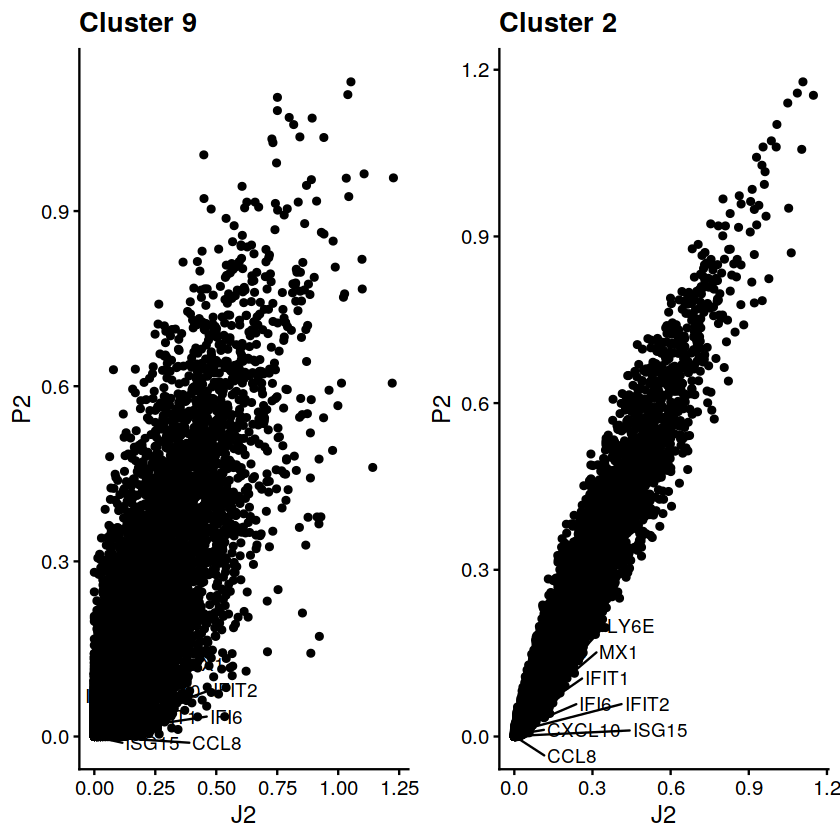

In [179]:
genes.to.label = c("ISG15", "LY6E", "IFI6", "ISG20", "MX1", "IFIT2", "IFIT1", "CXCL10", "CCL8")
p1 <- ggplot(avg.t.cells, aes(J2, P2)) + geom_point() + ggtitle("Cluster 9")
p1 <- LabelPoints(plot = p1, points = genes.to.label, repel = TRUE)
p2 <- ggplot(avg.cd14.mono, aes(J2, P2)) + geom_point() + ggtitle("Cluster 2")
p2 <- LabelPoints(plot = p2, points = genes.to.label, repel = TRUE)
plot_grid(p1, p2)

In [79]:
sessionInfo()

R version 4.0.2 (2020-06-22)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /data/isshamie/software/anaconda3/envs/mito_trace/lib/libopenblasp-r0.3.12.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] future_1.21.0             magrittr_2.0.1           
 [3] data.table_1.14.0         patchwork_1.1.1          
 [5] ggplot2_3.3.3             EnsDb.Hsapiens.v75_2.99.0
 [7] ensembldb_2.14.1          AnnotationFilter_1.14.0  
 [9] GenomicFeatures_1.42.3    An